In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import json
import nltk
import wordcloud
import spacy

In [15]:
df = pd.read_csv("../data/food-com/RAW_recipes.csv")
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [5]:
print(f"Number of recipes before dropna: {len(df)}")
df.dropna(inplace=True, subset=["steps","ingredients"])
print(f"Number of recipes after dropna: {len(df)}")

Number of recipes before dropna: 231637
Number of recipes after dropna: 231637


## Ingredients

In [46]:
x = df.ingredients.iloc[0]


['winter squash',
 'mexican seasoning',
 'mixed spice',
 'honey',
 'butter',
 'olive oil',
 'salt']

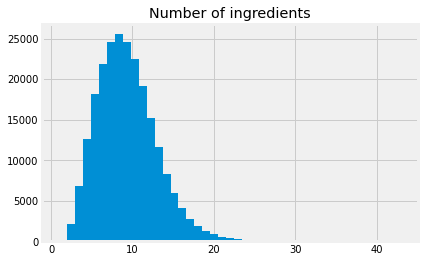

Median number of ingredients: 9.0
Std. deviation of number of ingredients: 3.73


In [47]:
import ast

def count_ingredients(ingredients):
    #ingredients list was saved as str and thus needs to be parsed as list again
    ingredients = ast.literal_eval(ingredients)
    
    if isinstance(ingredients, list):
        return len(ingredients)
    else:
        return 0

df['n_ingredients'] = df.ingredients.apply(count_ingredients)

#plot distribution
plt.title("Number of ingredients")
plt.hist(df.n_ingredients.tolist(), bins=max(df.n_ingredients.tolist()))
plt.show()

print(f"Median number of ingredients: {df.n_ingredients.median()}")
print(f"Std. deviation of number of ingredients: {df.n_ingredients.std():.2f}")

The median number of ingredients is 9, which seems plausible. There are some recipes that require a lot of ingredients, i.e. the distribution is long tailed. However, the majority has 1-20 ingredients. There are some ingredients that require no ingredients (i.e. those are nan values or empty lists)

In [11]:
for i in range(0):
    recipe = df[df.n_ingredients == 0].iloc[i]
    print("{}: {}".format(recipe.title, len(recipe.instructions)))

As one can see, many recipes with no ingredients are instructions for common task or general cooking skills, like grilling or preparing water baths.

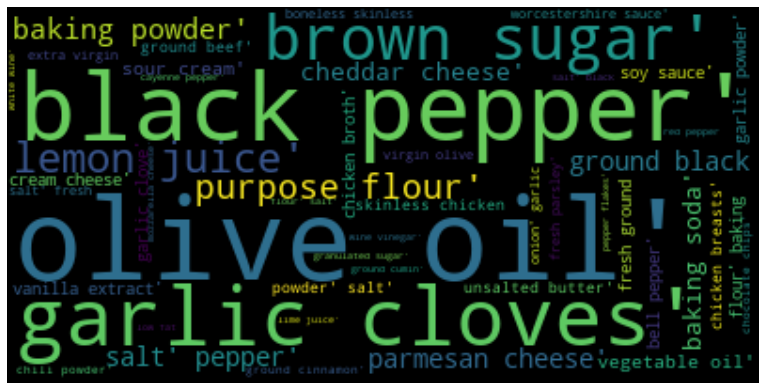

In [48]:
total_ingredients = nltk.flatten(df.ingredients.tolist())
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(total_ingredients))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

As one can see, olive oil is the most prominent ingredient. However, the ingredients include adjectives (chopped, fresh, unstalted, large etc.). This needs to be cleaned to obtain the real ingredients.

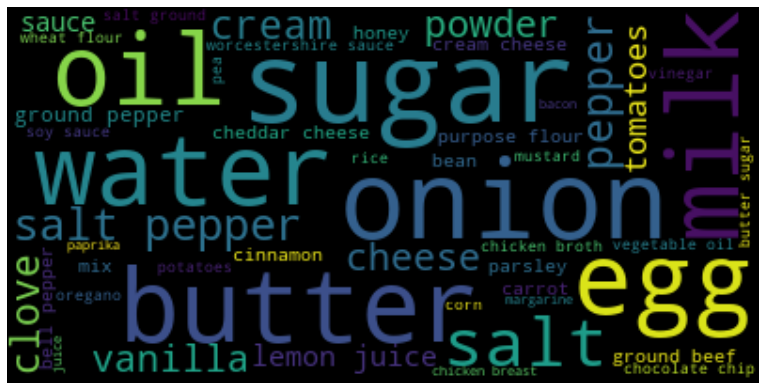

In [49]:
nlp = spacy.load("en_core_web_sm")
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if word.pos_ == "NOUN"]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

This looks better, but still cup is the most prominent word although it is a measure and not an ingredient. This probably has to be removed manually via a stopword list, tablespoon, teaspoon, pund, similarly. Interestingly words like vegetable are of course nouns but most likely appear in combination with stock for example where they are adjectives. This has to be taken care of. Why are lentils so prominent?

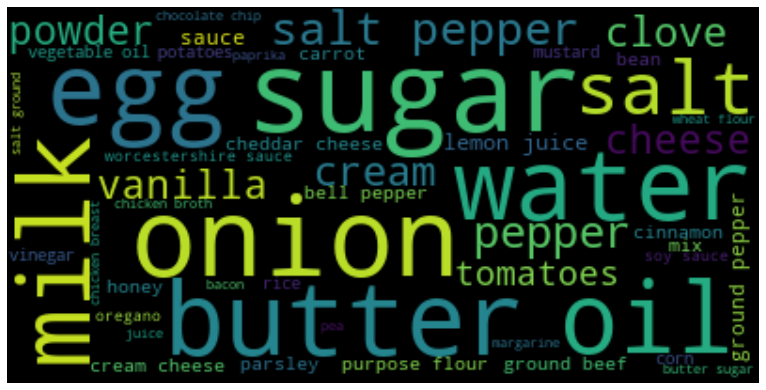

In [50]:
# without units (special stopwords)
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "ounce", "ounces","slice","slices", "piece", "pieces", "ADVERTISEMENT"}
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if (word.pos_ == "NOUN" and not word.is_stop)]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")


## Directions

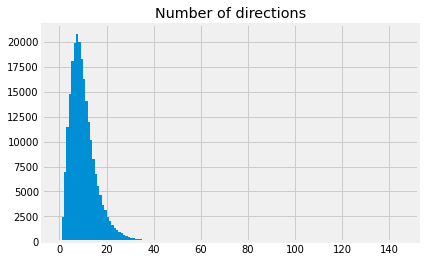

Median number of directions: 9.0
Std. deviation of number of directions: 6.00


In [56]:
def count_directions(directions):
    directions = ast.literal_eval(directions)
    if isinstance(directions, list):
        return len(directions)
    else:
        return 0

df['n_directions'] = df.steps.apply(count_directions)

#plot distribution
plt.title("Number of directions")
plt.hist(df.n_directions.tolist(), bins=max(df.n_directions.tolist()))
plt.show()

print(f"Median number of directions: {df.n_directions.median()}")
print(f"Std. deviation of number of directions: {df.n_directions.std():.2f}")

In [59]:
df[df.n_steps>100].head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,n_directions
1627,5 cheese crab lasagna with roasted garlic and ...,65007,245,87300,2003-06-18,"['weeknight', 'time-to-make', 'course', 'main-...","[442.8, 35.0, 27.0, 33.0, 50.0, 60.0, 10.0]",108,['roast garlic: place oven rack on second notc...,"this creamy, gooey, gorgeous white lasagna wil...","['garlic', 'extra virgin olive oil', 'dry whit...",24,108
51528,chocolate raspberry mousse truffle cake rasp...,192468,240,232669,2006-10-27,"['time-to-make', 'course', 'main-ingredient', ...","[697.4, 57.0, 249.0, 9.0, 13.0, 105.0, 29.0]",113,"['make the chocolate sour cream cake:', 'prehe...","this recipe is the winner, hands down! just in...","['cake flour', 'baking soda', 'salt', 'godiva ...",24,113
51532,chocolate raspberry ruffle cake,156874,1080,10033,2006-02-21,"['time-to-make', 'course', 'main-ingredient', ...","[5080.8, 616.0, 967.0, 25.0, 147.0, 1211.0, 12...",110,['first of all: these are not typical directio...,"alice medrich recipe, found in baking with jul...","['unsalted butter', 'pure vanilla extract', 'a...",13,110
78633,easy yeast bread with variations,158120,210,182358,2006-02-28,"['time-to-make', 'course', 'preparation', 'hea...","[1784.5, 62.0, 104.0, 151.0, 103.0, 42.0, 99.0]",145,"['white bread:', 'lightly spooning flour into ...",found online in response to a request and now ...,"['all-purpose flour', 'dry yeast', 'sugar', 's...",8,145


In [69]:
[print(step) for step in ast.literal_eval(df.iloc[78633].steps)]

white bread:
lightly spooning flour into measuring cup & leveling off , measure out 2 1 / 2 cups flour
combine flour , dry yeast , sugar , & salt in a large mixer bowl
blend
in a medium saucepan , combine water , milk , and oil
heat until very warm
add eggs and liquid to flour mixture
mixing - blend at low speed until moistened
beat 3 minutes at medium speed
with a wooden spoon , stir in an additional 3 to 3-1 / 2 cups of flour to form a sticky dough
in bowl or on a floured board , gradually work in 1 / 2 to 1-1 / 2 cups more flour , kneading or working in with hands until dough is smooth , pliable and no longer sticky
rising - place dough in a greased bowl
cover with a cloth or loose fit lid
let rise in a warm place until light and double in size , about 45 minutes
shaping & baking:punch down dough to remove air bubbles
divide dough into two parts
from dough into desired shapes
place in greased pans according to shaping and baking directions
cover , let rise in a warm place until ligh

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Interestingly, ther are quite a lot of recipes with only a few directions (i.e. simple recipes). Only a samll number of recipes have more than 10 directions.

In [27]:
for i in range(0):
    recipe = df[df.n_directions == 0].iloc[i]
    print("{}: {}".format(recipe.title, len(recipe.ingredients)))

While some recipes with no instructions also have no ingredients, there are some which should have instructions. Interesstingly, most of the recipes are for drinks.

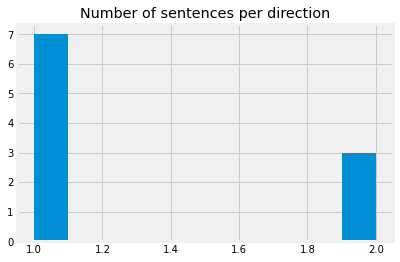

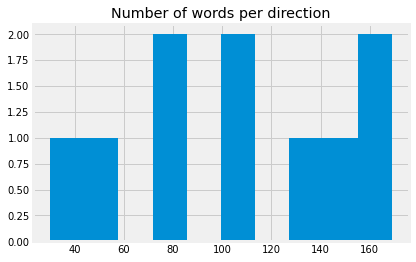

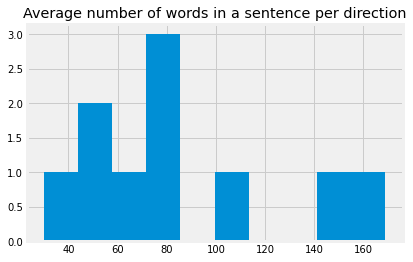

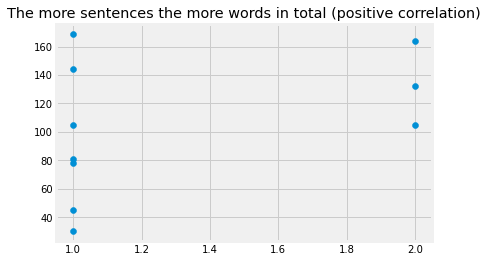

In [70]:
#number of words, sentences in directions 
processed_directions = [nlp(direction) for direction in nltk.flatten(df.steps.tolist()[:10]) if isinstance(direction, str)]
sentences_per_direction = [len(list(processed_direction.sents)) for processed_direction in processed_directions]
plt.title("Number of sentences per direction")
plt.hist(sentences_per_direction)
plt.show()

words_per_direction = [len(processed_direction) for processed_direction in processed_directions]
plt.title("Number of words per direction")
plt.hist(words_per_direction)
plt.show()

plt.title("Average number of words in a sentence per direction")
plt.hist(np.array(words_per_direction) / np.array(sentences_per_direction))
plt.show()

plt.title("The more sentences the more words in total (positive correlation)")
plt.scatter(sentences_per_direction, words_per_direction)
plt.show()

This is varying quite a lot! So there is no clue if the directions are especially long or short. Of course the correlation between #words and #sentences is positive. Interestingly it is more a cloud than a line, so some variation.

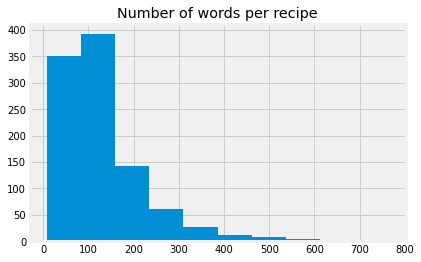

In [71]:
def count_words(directions):
    return len(nlp(directions)) 

df['word_count'] = df.steps[:1000].apply(count_words)
plt.title("Number of words per recipe")
plt.hist(df.word_count.tolist())
plt.show()